# **UGST4088 — Introduction to Machine Learning and Data Mining 2025/26 Fall**  
## **Abnormal Heartbeat Audio Detection Comparison between a Convolutional Neural Network on Mel Spectrograms and Gradient Boosting on Audio Features**

**Name:** Zeteny Cseresznyes   
**Email:** [cseresznyes_zeteny@student.ceu.edu](mailto:cseresznyes_zeteny@student.ceu.edu)  

*Date:* 15.12.2025.

## Data Source
### Training Data
- Oliveira, J., Renna, F., Costa, P., Nogueira, M., Oliveira, A. C., Elola, A., Ferreira, C., Jorge, A., Bahrami Rad, A., Reyna, M., Sameni, R., Clifford, G., & Coimbra, M. (2022). The CirCor DigiScope Phonocardiogram Dataset (version 1.0.3). PhysioNet. RRID:SCR_007345. https://doi.org/10.13026/tshs-mw03
- J. H. Oliveira, F. Renna, P. Costa, D. Nogueira, C. Oliveira, C. Ferreira, A. Jorge, S. Mattos, T. Hatem, T. Tavares, A. Elola, A. Rad, R. Sameni, G. D. Clifford, & M. T. Coimbra (2021). The CirCor DigiScope Dataset: From Murmur Detection to Murmur Classification. IEEE Journal of Biomedical and Health Informatics, https://doi.org/10.1109/JBHI.2021.3137048
- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. RRID:SCR_007345.

Quick access: https://physionet.org/content/circor-heart-sound/1.0.3/

### Test Data
- Bentley, P., Nordehn, G., Coimbra, M., & Mannor, S. (2011). The PASCAL Classifying Heart Sounds Challenge 2011 (CHSC2011) Results. Retrieved December 8, 2025, from http://www.peterjbentley.com/heartchallenge/index.html

Quick access: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds/data

## Data Preperation

### **Importing Modules**

In [50]:
# data preperation
import pandas as pd
import numpy as np

# image and audio processing
from scipy.io import wavfile
import librosa
from IPython.display import Audio

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and augmentation for the model
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# deep learning modules
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, TimeDistributed,
    Dense, Dropout, BatchNormalization, LSTM, Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Recall, Precision, AUC

# xgboost module
import optuna as opt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# other modules
import random
import re

# access file
import os

# for google colab environment
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/ColabNotebooks/circor

# # for local environment
# %cd "C:\Users\Hp\HP_FILES\25F\MLDM25F_HW\circor"

# hide warnings
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/ColabNotebooks/circor


### **Loading the Data**

#### Reading the Data

In [51]:
# read csv file
df = pd.read_csv("circor.csv")

# show head
df.head(10)

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.90,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.10,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.10,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.90,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.20,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
6,23625,AV+PV+TV+MV,Child,Female,92.0,14.00,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,50379.0
7,24160,AV+PV+TV+MV,Child,Female,98.0,17.66,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
8,29045,AV+PV+TV+MV,Child,Female,88.0,12.50,False,Present,AV+MV+PV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
9,29378,AV+MV,Child,Female,82.0,10.70,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


#### Dividing Patients to Observations

In [52]:
# split locations to list
df['locations_list'] = df['Recording locations:'].str.split('+')

# put lists into different rows
df_exp = df.explode('locations_list').rename(columns={'locations_list': 'Location'})

# drop the combined rows
df_exp = df_exp.drop(columns=['Recording locations:'])

# show top 10 rows
df_exp.head(10)

,Patient ID,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,Systolic murmur timing,...,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID,Location
0,2530,Child,Female,98.0,15.9,False,Absent,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,AV
0,2530,Child,Female,98.0,15.9,False,Absent,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,PV
0,2530,Child,Female,98.0,15.9,False,Absent,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,TV
0,2530,Child,Female,98.0,15.9,False,Absent,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,MV
1,9979,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,Holosystolic,...,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,AV
1,9979,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,Holosystolic,...,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,PV
1,9979,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,Holosystolic,...,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,TV
1,9979,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,Holosystolic,...,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,MV
2,9983,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,AV
2,9983,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN,PV


#### Missing Values

In [53]:
df_exp.isna().sum()

,0
Patient ID,0
Age,239
Sex,0
Height,355
Weight,329
Pregnancy status,0
Murmur,0
Murmur locations,2547
Most audible location,2547
Systolic murmur timing,2551


#### Matching Observations to Filenames of Sound Recordings

In [54]:
# saving folder name
folder = r"circor-wav"
import os

# temporary list for new rows
new_rows = []

# iterate over the original df_exp
for idx, row in df_exp.iterrows():
    patient_id = str(row["Patient ID"])
    loc = row["Location"]
    outcome = row["Outcome"]

    prefix = f"{patient_id}_{loc}"
    matches = [f for f in os.listdir(folder)
               if f.startswith(prefix) and f.endswith(".wav")]

    if not matches:
        continue

    # update first match in the original row
    df_exp.at[idx, "Filename"] = matches[0]
    df_exp.at[idx, "Version"] = 1

    # for additional matches, store as new rows
    for _, fname in enumerate(matches[1:], start=2):
        new_row = row.copy()
        new_row["Filename"] = fname
        new_rows.append(new_row)

# append any additional rows to the original df_exp
if new_rows:
    df_exp = pd.concat([df_exp, pd.DataFrame(new_rows)], ignore_index=True)

# drop duplicates
df_exp = df_exp.drop_duplicates()

# select columns
df_exp = df_exp[["Outcome", "Filename", "Location"]]

# encode outcome as binary
df_exp["Outcome"] = df_exp["Outcome"].apply(lambda x: 0 if x == "Normal" else 1)

# show top 10 rows
df_exp.head(10)

,Outcome,Filename,Location
0,1,2530_MV.wav,AV
1,1,2530_MV.wav,PV
2,1,2530_MV.wav,TV
3,1,2530_MV.wav,MV
4,1,9979_MV.wav,AV
5,1,9979_MV.wav,PV
6,1,9979_MV.wav,TV
7,1,9979_MV.wav,MV
8,1,9983_MV.wav,AV
9,1,9983_MV.wav,PV


### **Splitting the Data**

In [55]:
# train test split
train, eval = train_test_split(df_exp,
                                test_size=0.1, # 10%
                                random_state=42,
                                stratify=df_exp['Outcome'])  # class balance)

### **Inspection of the Data**

#### Listening

In [56]:
file_to_play = os.path.join(folder, "84942_TV.wav")
Audio(file_to_play)


#### Recording length

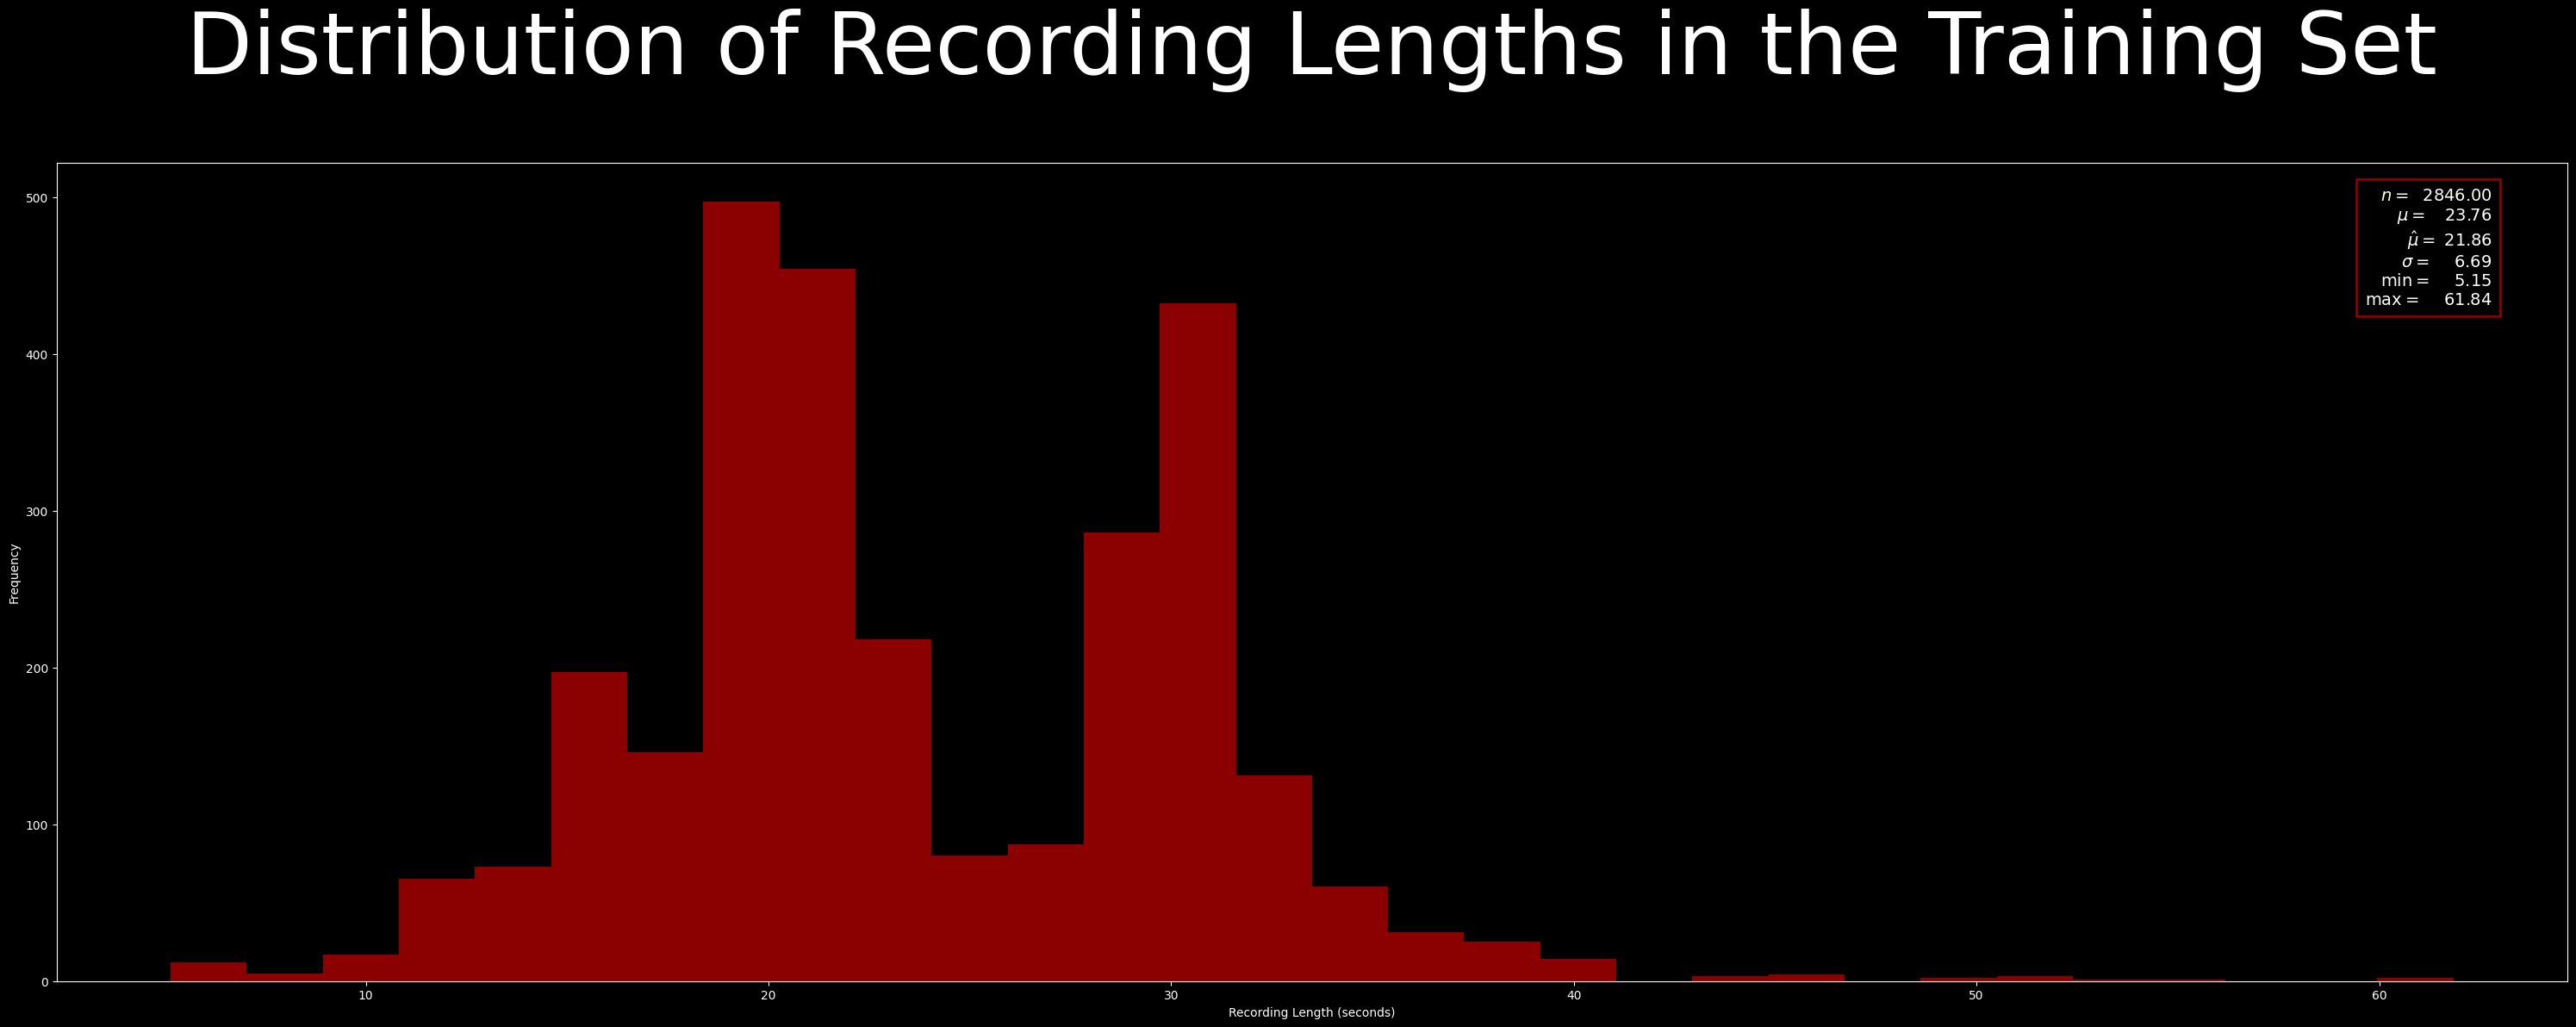

In [57]:
# function to extract duration
def get_duration_from_name(name):
    path = os.path.join(folder, name)

    # if does not exist
    if not os.path.exists(path):
        print(f"Missing: {path}")
        return None

    return librosa.get_duration(path=path)

# apply function to get durations
train["Recording Length"] = train["Filename"].apply(get_duration_from_name)

# histogram
data = train["Recording Length"]

# stats
stats_text = (
    f"$n =$  {data.count():.2f}\n"
    f"$\\mu =$   {data.mean():.2f}\n"
    f"$\\hat\\mu =$ {data.median():.2f}\n"
    f"$\\sigma =$    {data.std():.2f}\n"
    f"$\\min =$    {data.min():.2f}\n"
    f"$\\max =$    {data.max():.2f}"
)

# plot
plt.style.use('dark_background')
plt.figure(figsize=(30, 12))
plt.hist(data, bins=30, color = "darkred")

# text box
plt.text(
    0.97, 0.97, stats_text,
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="square,pad=0.5", fc="black", ec="darkred", lw=2)
)

# show
plt.xlabel("Recording Length (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Recording Lengths in the Training Set", fontsize = 72, y = 1.1)
plt.grid(False)
plt.tight_layout()
plt.show()

#### Sampling rate

In [58]:
y, sr = librosa.load(file_to_play, sr=None)
print(sr)

4000


#### Signals and Mel-Spectrograms

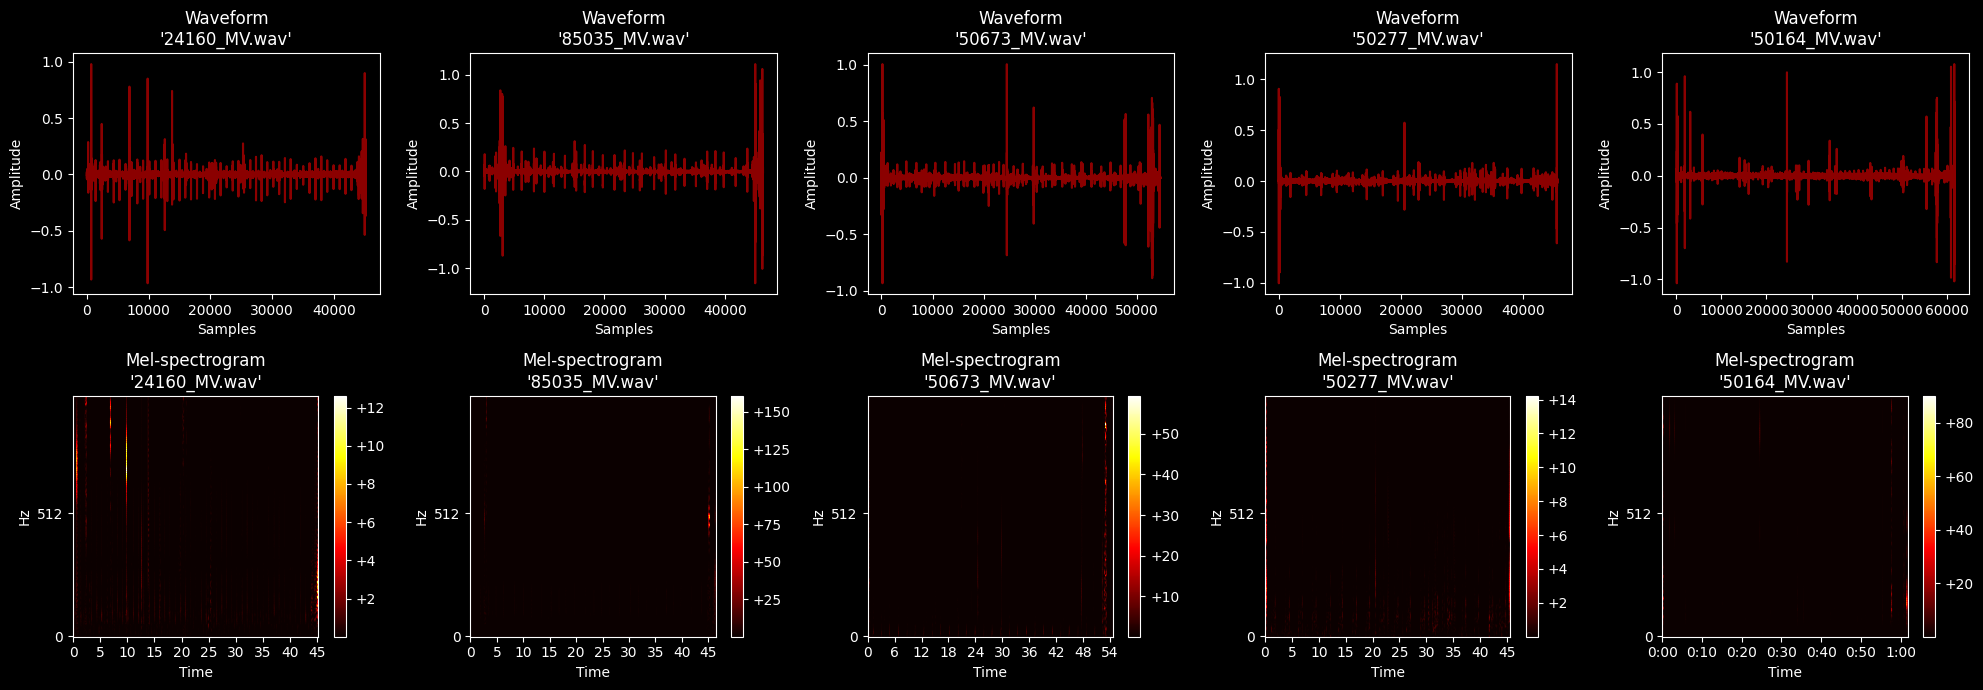

In [59]:
# number of examples to plot
n_examples = 5
random.seed(42)
examples = random.sample(range(len(train)), n_examples)

# 2 by 5 subplots
fig, axes = plt.subplots(2, n_examples, figsize=(4*n_examples, 7))

# iterate over examples
for col, idx in enumerate(examples):

    # get file path
    file = train.iloc[idx]["Filename"]
    filepath = os.path.join(folder, file)

    # load audio
    signal, sr = librosa.load(filepath, sr=2000)

    # mel-spectrogram
    mel = librosa.feature.melspectrogram(
                    y=signal,
                    sr=sr,
                    n_fft=1024,         # 1024 samples / 2000 Hz = 512 ms window (samples)
                    hop_length=64,      # 64 samples / 2000 Hz = 32 ms hop
                    win_length=512,     # 512 samples / 2000 Hz = 256 ms window (smoothed)
                    n_mels=256,         # 64 mel freq bands (number of mel frequency)
                    fmin=25,            # heart sounds are very low freq
                    fmax=800,           # heart sounds rarely exceed 600 Hz
    )

    # plot waveform
    axes[0, col].plot(signal, color='darkred')
    axes[0, col].set_title(f"Waveform\n'{file}'")
    axes[0, col].set_xlabel("Samples")
    axes[0, col].set_ylabel("Amplitude")

    # plot mel-spectrogram
    img = librosa.display.specshow(
        mel, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=axes[1, col], cmap='hot')
    axes[1, col].set_title(f"Mel-spectrogram\n'{file}'")
    fig.colorbar(img, ax=axes[1, col], format="%+2.0f")

# show
plt.tight_layout()
plt.show()

#### Correlation Heatmap

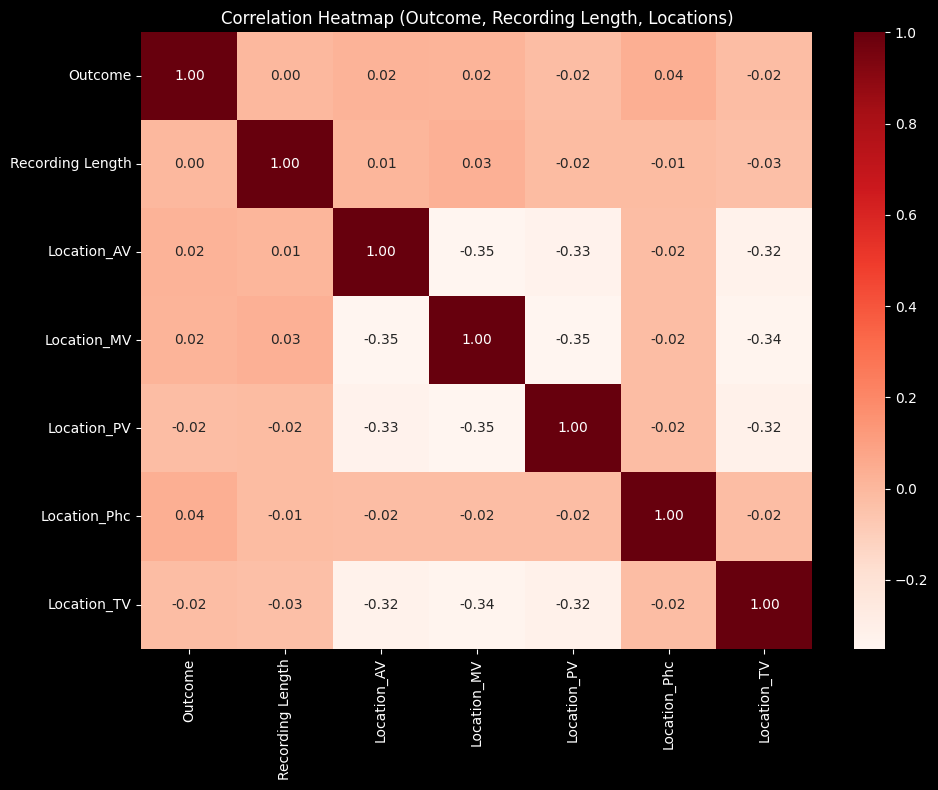

In [60]:
# encode locations
location_dummies = pd.get_dummies(train["Location"], prefix="Location")

# combine into a new dataframe
df_corr = pd.concat([train[["Outcome", "Recording Length"]], location_dummies], axis=1)

# corr matrix
corr_matrix = df_corr.corr()

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds", cbar=True)
plt.title("Correlation Heatmap (Outcome, Recording Length, Locations)")
plt.tight_layout()
plt.show()

#### Class Balance

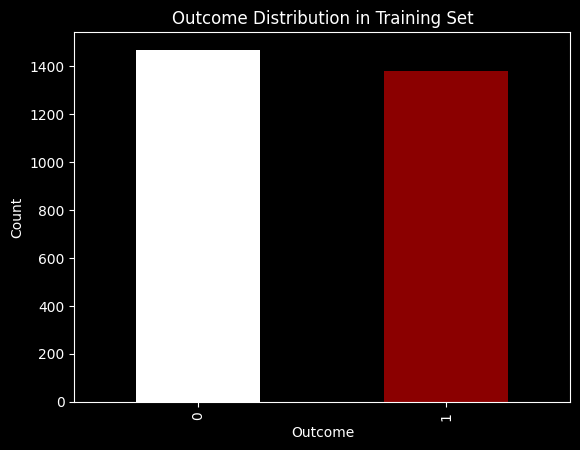

In [61]:
# plot as bar chart
train["Outcome"].value_counts().plot(kind='bar', color=['white','darkred'])
plt.title("Outcome Distribution in Training Set")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()


### **Audio Preprocessor for CNN**

In [62]:
# custom preprocessor class for heartbeat audio
class AudioPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom transformer for mel-spectrogram preprocessing.
    """

    # initialize
    def __init__(self,
                 folder="circor-wav",
                 target_duration=5,
                 n_mels=64,
                 input_size=128):
        self.folder = folder
        self.target_duration = target_duration
        self.n_mels = n_mels
        self.input_size = input_size

    # fit
    def fit(self, X, y=None):
        return self

    # transform function
    def transform(self, X):

        # making sure object is dataframe first
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input X must be a DataFrame with a 'Filename' column.")

        # list to store mel-spectrogram images
        mel_images = []

        # iterate rows
        for _, row in X.iterrows():

            # filename and directory path
            file = row["Filename"]
            filepath = os.path.join(self.folder, file)

            # skip missing files, if any
            if not os.path.isfile(filepath):
                print("Missing:", filepath)
                continue

            # load audio
            signal, sr = librosa.load(filepath, sr=2000)

            # pad until target duration or sample from middle
            target_len = int(self.target_duration * sr)
            if len(signal) < target_len:
                pad = target_len - len(signal)
                signal = np.pad(signal, (0, pad))
            elif len(signal) > target_len:
                start = len(signal)//2 - target_len//2
                signal = signal[start:start+target_len]

            # turn to mel-spectrogram
            mel = librosa.feature.melspectrogram(
                    y=signal,
                    sr=sr,
                    n_fft=1024,         # 1024 samples / 2000 Hz = 512 ms window (samples)
                    hop_length=256,     # 256 samples / 2000 Hz = 128 ms hop
                    win_length=512,     # 512 samples / 2000 Hz = 256 ms window (smoothed)
                    n_mels=64,          # 64 mel freq bands (number of mel frequency)
                    fmin=25,            # heart sounds are very low freq
                    fmax=800,           # heart sounds rarely exceed 600 Hz
                    center=False
            )

            # convert to dB
            mel_db = librosa.power_to_db(mel, ref=np.max)

            # normalization of each mel-spectrogram
            mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

            # final scaling to float
            mel_img = mel_db.astype(np.float32)

            # append to list
            mel_images.append(mel_img)

        # final shape (batch_size, channels, height, width)
        # = (N, 1, n_mels, 1 + floor((target_duration * sr - n_fft) / hop_length))
        # = (N, 1, 64, 36)
        X_out = np.array(mel_images)[:, np.newaxis, :, :]
        return X_out

# save as preprocessor
preprocessor_cnn = AudioPreprocessor()

#### AudioPreprocessor Visualization

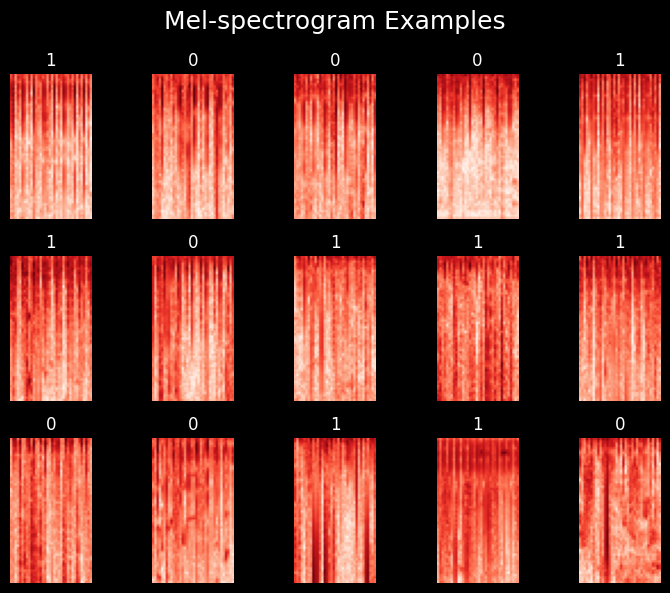

In [63]:
# random indices
indices = np.random.choice(len(train), 15, replace=False)
audiopreptrain = preprocessor_cnn.transform(train.iloc[indices].drop(columns=["Outcome"]))

# calculate grid size
rows_show, cols_show = 3, 5
num_show = rows_show * cols_show

# plot them
plt.style.use('dark_background')
plt.figure(figsize=(cols_show * 1.5, rows_show * 2))
plt.suptitle("Mel-spectrogram Examples", fontsize=18)
for i, idx in enumerate(indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(audiopreptrain[i].squeeze(), cmap='Reds')
    plt.title(train['Outcome'].iloc[idx])
    plt.axis('off')

# show plot
plt.tight_layout()
plt.show()

### **Data Augmentation for CNN**

In [64]:
# custom data generator with augmentation
class MelAudioDataGenerator(Sequence):
    """
    Custom keras data generator for audio files converted to mel-spectrograms,
    with pitch shift, random cropping, noise, and SpecAugment.
    """

    # initialize
    def __init__(self, df, folder="circor-wav", batch_size=32,
                 target_duration=5, n_mels=64, input_size=128,
                 noise_level=0.005, freq_mask_ratio=0.1,
                 shuffle=True):
        self.df = df.reset_index(drop=True)
        self.folder = folder
        self.batch_size = batch_size
        self.target_duration = target_duration
        self.n_mels = n_mels
        self.input_size = input_size
        self.noise_level = noise_level
        self.freq_mask_ratio = freq_mask_ratio
        self.shuffle = shuffle
        self.on_epoch_end()

    # number of batches
    def __len__(self):

        # number of batches per epoch
        return int(np.ceil(len(self.df) / self.batch_size))

    # shuffle indices on epoch end
    def on_epoch_end(self):

        # shuffle dataframe indices
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    # get item in correct shape
    # X_batch shape = (batch_size, 1, n_mels, 1 + floor((target_duration * sr - n_fft) / hop_length))
    def __getitem__(self, index):

        # generate indices for this batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        X_batch = []
        y_batch = []

        # iterate rows in batch
        for _, row in batch_df.iterrows():
            file = row["Filename"]
            y = row["Outcome"]

            # augment and convert to mel-spectrogram
            mel_img = self._augment_and_mel(file)
            X_batch.append(mel_img)
            y_batch.append(y)

        # convert to arrays
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)

        return X_batch, y_batch

    # mel spec item and augment
    def _augment_and_mel(self, file):
        filepath = os.path.join(self.folder, file)

        # load audio
        signal, sr = librosa.load(filepath, sr=2000)
        target_len = self.target_duration * sr

        # random cropping/padding
        if len(signal) < target_len:
            pad = target_len - len(signal)
            signal = np.pad(signal, (0, pad))
        elif len(signal) > target_len:
            start = random.randint(0, len(signal) - target_len)
            signal = signal[start:start+target_len]

        # gaussian noise
        noise = np.random.normal(0, self.noise_level, size=signal.shape)
        signal = signal + noise

        # compute mel-spectrogram
        mel = librosa.feature.melspectrogram(
                    y=signal,
                    sr=sr,
                    n_fft=1024,         # 1024 samples / 2000 Hz = 512 ms window (samples)
                    hop_length=256,     # 256 samples / 2000 Hz = 128 ms hop
                    win_length=512,     # 512 samples / 2000 Hz = 256 ms window (smoothed)
                    n_mels=64,          # 64 mel freq bands (number of mel frequency)
                    fmin=25,            # heart sounds are very low freq
                    fmax=800,           # heart sounds rarely exceed 600 Hz
                    center = False
        )

        # convert to dB
        mel = librosa.power_to_db(mel, ref=np.max)

        # SpecAugment-style freq masking
        n_freq = mel.shape[0]

        # freq mask
        f = int(n_freq * self.freq_mask_ratio)
        f0 = random.randint(0, n_freq - f)
        mel[f0:f0+f, :] = 0

        # normalize
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        # add channel dimension
        mel_img = mel[np.newaxis, :, :]

        return mel_img

#### Data Augmentation Visualization

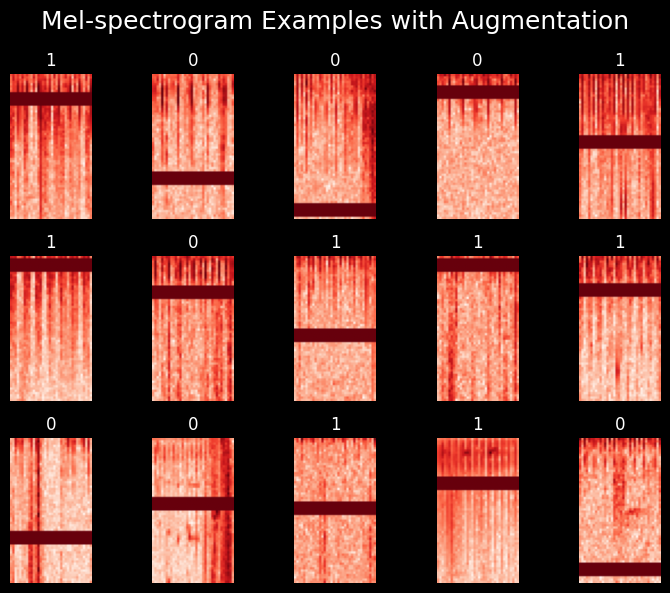

In [65]:
# create generator for example
audiogentrain = MelAudioDataGenerator(train)

# plot
plt.style.use("dark_background")
plt.figure(figsize=(cols_show * 1.5, rows_show * 2))
plt.suptitle("Mel-spectrogram Examples with Augmentation", fontsize=18)

# loop through selected indices
for i, idx in enumerate(indices):

    # get filename and label
    file = train.iloc[idx]["Filename"]
    label = train.iloc[idx]["Outcome"]

    # call augmentation method on this file
    mel_img = audiogentrain._augment_and_mel(file)

    # plot
    plt.subplot(rows_show, cols_show, i + 1)
    plt.imshow(mel_img.squeeze(), cmap='Reds')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### **Feature Extraction for XGBoost**

In [66]:
# extract features function
def extract_heartbeat_features(file_path):
    """
    Extract heartbeat features from audio, returning a one-dimensional feature vector.
    """
    # loading audio
    signal, sr = librosa.load(file_path, sr=4000)

    # pad until target duration or sample from middle
    target_duration = 5
    target_len = int(target_duration * sr)
    if len(signal) < target_len:
        pad = target_len - len(signal)
        signal = np.pad(signal, (0, pad))
    elif len(signal) > target_len:
        start = len(signal)//2 - target_len//2
        signal = signal[start:start+target_len]

    # time dominant: zero-crossing rate (freq sign changes per frame)
    zcr = np.mean(librosa.feature.zero_crossing_rate(signal))

    # time dominant: RMS energy (overall amplitude of the signal)
    rms = np.mean(librosa.feature.rms(y = signal))

    # mel-frequency cepstral coefficients are compact numerical representations of the spectral envelope
    mfccs = librosa.feature.mfcc(
        y=signal,
        sr=sr,
        n_mfcc=12,          # number of MFCC coefficients
        n_fft=1024,         # size of FFT window
        hop_length=256,     # step between successive frames
        win_length=512,     # window length for FFT
        fmin=25,            # lowest frequency considered
        fmax=600            # highest frequency considered
    )

    # spectrum dominant: store the mean
    mfcc_mean = np.mean(mfccs, axis=1)

    # spectrum dominant: store the std deviation
    mfcc_std = np.std(mfccs, axis=1)

    # spectral centroid: "center of mass" of frequency spectrum
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))

    # spectral bandwidth: variance around the centroid
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sr))

    # tempogram: dominant tempo over time
    tempogram = np.mean(librosa.feature.tempogram(y=signal, sr=sr))

    # save features into a single 1D vector
    feature_names = ['zcr', 'rms', 'spec_cent', 'spec_bw'] + \
                [f'mfcc_mean_{i}' for i in range(len(mfcc_mean))] + \
                [f'mfcc_std_{i}' for i in range(len(mfcc_std))] + \
                ['tempogram']
    features = [zcr, rms, spec_cent, spec_bw, *mfcc_mean, *mfcc_std, tempogram]

    return features, feature_names

# audio feature extractor-preprocessor class
class AudioFeaturePreprocessor(BaseEstimator, TransformerMixin):
    """
    Scikit-learn style preprocessor which calls custom extract_heartbeat_features() function
    and then scales features.
    """

    # initialize
    def __init__(self, folder="circor-wav"):
        self.folder = folder
        self.scaler = RobustScaler()
        self.feature_names_ = None

    # fit scaler to train
    def fit(self, X, y=None):

        # compute features for X
        feature_matrix = self._extract_all_features(X)

        # fit robustscaler on raw features
        self.scaler.fit(feature_matrix)

        return self

    # transform function (feature extractor)
    def transform(self, X):

        # compute raw features
        feature_matrix = self._extract_all_features(X)

        # scale features using robustscaler
        scaled = self.scaler.transform(feature_matrix)

        return scaled.astype(np.float32)

    # read audio files for feature extraction
    def _extract_all_features(self, X):

        # input must be dataframe with Filename
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a dataframe containing 'Filename'")

        rows = []

        # iterate over rows
        for _, row in X.iterrows():
            fname = row["Filename"]
            filepath = os.path.join(self.folder, fname)

            # skip missing files
            if not os.path.isfile(filepath):
                print("Missing:", filepath)
                continue

            # use your function
            features, feature_names = extract_heartbeat_features(filepath)

            rows.append(features)

        # infer feature names once
        self.feature_names_ = feature_names

        return np.array(rows)

    # if feature names are needed
    def get_feature_names_out(self):
        return np.array(self.feature_names_)

# save preprocessor
preprocessor_xgb = AudioFeaturePreprocessor()

## CNN: Model Selection and Fitting

### **Architecture**

In [67]:
# define input
input_shape = (1, 64, 36)

# model architectures
def create_cnn_model():
    model = Sequential([

        # make sure about input shape
        Input(shape=input_shape),

        # temporal convolutional, batch and downsampling layer
        Conv2D(32, (1,3), activation='relu', data_format='channels_first'),
        BatchNormalization(),
        MaxPooling2D((2,2), data_format='channels_first'),

        Conv2D(64, (3,3), activation='relu', data_format='channels_first'),
        BatchNormalization(),
        MaxPooling2D((2,2), data_format='channels_first'),

        # flatten for fully connected layers
        Flatten(),

        # fully connected
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # compile model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=["recall", "auc"])

    return model

### **Model Preperation**

In [68]:
# batch size
batch_size = 32

# instantiate data generator
train_gen = MelAudioDataGenerator(train, batch_size=batch_size, shuffle=True)

# validation processor
X_val = preprocessor_cnn.transform(eval.drop(columns=["Outcome"]))
y_val = eval["Outcome"].values

# save model
model = create_cnn_model()

### **Model Training**

In [69]:
# fit model using the generator
history = model.fit(
    train_gen,
    validation_data=(X_val, y_val),
    epochs=12,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_recall', patience=3, restore_best_weights=True)]
)

Epoch 1/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - auc: 0.4725 - loss: 1.0051 - recall: 0.4718 - val_auc: 0.5563 - val_loss: 0.6908 - val_recall: 0.0327
Epoch 2/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - auc: 0.5176 - loss: 0.7138 - recall: 0.3988 - val_auc: 0.6146 - val_loss: 0.6851 - val_recall: 0.0719
Epoch 3/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - auc: 0.5325 - loss: 0.6959 - recall: 0.3234 - val_auc: 0.6410 - val_loss: 0.6850 - val_recall: 0.8497
Epoch 4/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - auc: 0.5501 - loss: 0.6909 - recall: 0.5828 - val_auc: 0.5916 - val_loss: 0.6862 - val_recall: 0.2092
Epoch 5/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - auc: 0.5521 - loss: 0.6864 - recall: 0.2718 - val_auc: 0.6283 - val_loss: 0.6839 - val_recall: 0.9020
Epoch 6/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - auc: 0.5628 - loss: 0.6863 - recall: 0.4274 - val_auc: 0.6238 - val_loss: 0.6814 - val_recall: 0.8366
Epoch 7/12
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - auc

### **Training and Validation AUC, Recall and Loss**

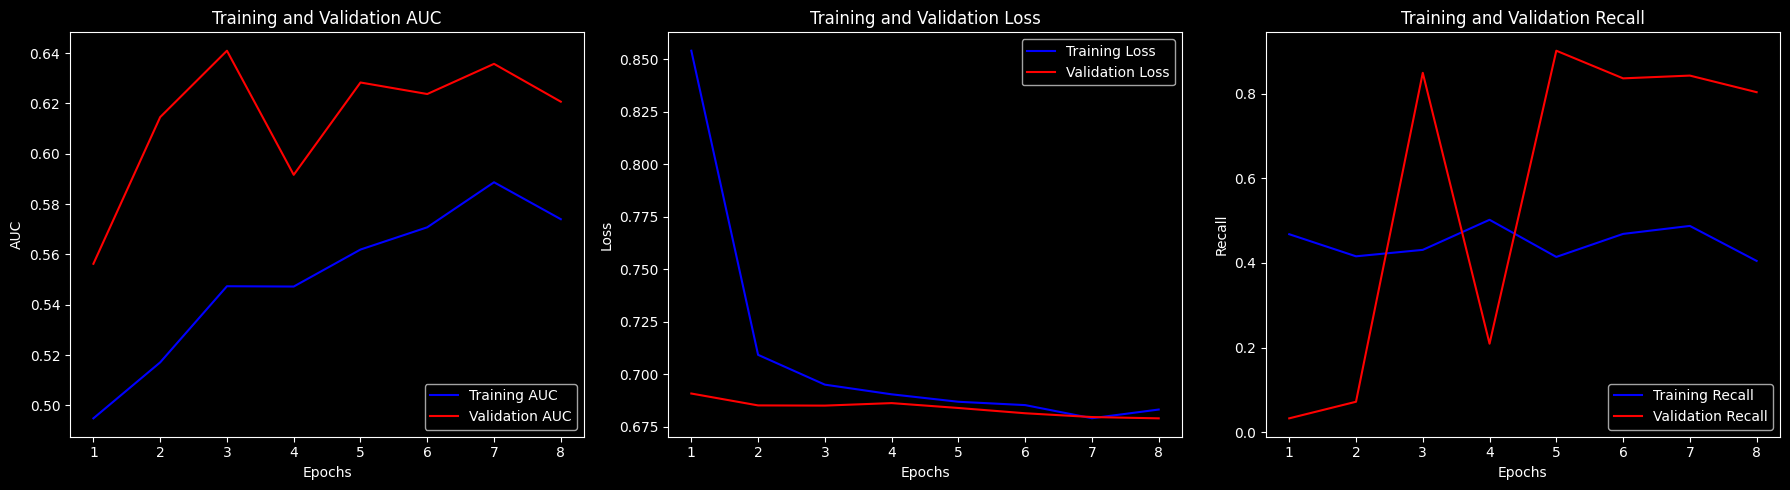

In [70]:
# plot training metrics history function
def plot_training_history(history):

    # extract wanted metrics
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    recall = history.history.get('recall')
    val_recall = history.history.get('val_recall')
    auc = history.history.get('auc')
    val_auc = history.history.get('val_auc')

    # number of epochs
    epochs = range(1, len(loss)+1)  # using loss to define epochs

    # plot AUC
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(epochs, auc, 'b-', label='Training AUC')
    if val_auc is not None:
        plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    # plot loss
    plt.subplot(1,3,2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot recall
    plt.subplot(1,3,3)
    plt.plot(epochs, recall, 'b-', label='Training Recall')
    if val_recall is not None:
        plt.plot(epochs, val_recall, 'r-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # show plots
    plt.tight_layout()
    plt.show()


# apply
plot_training_history(history)

## XGBoost: Hyperparameter Tuning and Fitting

### **Model Preperation**

In [71]:
# fit transform train
X_train_features = preprocessor_xgb.fit_transform(train.drop(columns=["Outcome"]))
y_train_features = train["Outcome"]

### **Hyperparameter Tuning**

In [72]:
# optuna trial for XGBoost Classifier
def objective(trial):

    # hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.5),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    # model
    model = XGBClassifier(**params)

    # cross-validation using recall
    scores = cross_val_score(
        model,
        X_train_features,
        y_train_features,
        scoring='recall',
        cv=5,
        n_jobs=-1
    )

    # maximize recall
    recall_mean = scores.mean()
    return recall_mean

# create study
study = opt.create_study(
    direction='maximize',
    study_name='xgb_binary_classification_opt'
)

# optimizer
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)

# best trial
print("Best trial:")
print("Best Recall (CV):", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-12-15 15:56:42,526] A new study created in memory with name: xgb_binary_classification_opt


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-15 15:56:44,849] Trial 0 finished with value: 0.9702503293807642 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.06528228434144416, 'subsample': 0.724348011988727, 'colsample_bytree': 0.6975955519245381, 'gamma': 1.1790348625388312}. Best is trial 0 with value: 0.9702503293807642.
[I 2025-12-15 15:56:46,295] Trial 1 finished with value: 0.969536231884058 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.15660915409070972, 'subsample': 0.9140664326716434, 'colsample_bytree': 0.7965164137470939, 'gamma': 1.1509735602143094}. Best is trial 0 with value: 0.9702503293807642.
[I 2025-12-15 15:56:49,375] Trial 2 finished with value: 0.968798418972332 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.029752202631520754, 'subsample': 0.7757628808525119, 'colsample_bytree': 0.7420658278040332, 'gamma': 0.27459220293257103}. Best is trial 0 with value: 0.9702503293807642.
[I 2025-12-15 15:56:49,870] Trial 3 finish

### **Fitting**

In [73]:
# make pipeline
xgb_model = make_pipeline(
    RobustScaler(),
    XGBClassifier(
        **study.best_params,
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic'
    )
)

# fit the model
xgb_model.fit(X_train_features, y_train_features)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9716024964727048, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.6050936873620538, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.015084559338278642, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=350, n_jobs=-1,
                               num_parallel_tree=None, ...))])

## Model Evaluation

### **Preprocessing Evaluation**

In [74]:
# transform evaluation set for XGBoost using the trained preprocessor
X_eval_features = preprocessor_xgb.transform(eval.drop(columns=["Outcome"]))
y_eval_features = eval["Outcome"]

# transform evaluation set for CNN using the mel-spectrogram preprocessor
X_eval_cnn = preprocessor_cnn.transform(eval)

### **Evaluation DataFrames**

In [75]:
# XGBoost predicted probabilities (class 1)
y_hat_xgb_proba = xgb_model.predict_proba(X_eval_features)[:, 1]

# XGBoost predicted class
y_hat_xgb = (y_hat_xgb_proba >= 0.5).astype(int)

# CNN predicted probabilities
y_hat_cnn_proba = model.predict(X_eval_cnn).flatten()

# CNN predicted class
y_hat_cnn = (y_hat_cnn_proba >= 0.5).astype(int)

# combined
y_hat_comb_proba = (y_hat_xgb_proba + y_hat_cnn_proba) / 2
y_hat_comb = (y_hat_comb_proba >= 0.5).astype(int)

# create df
df_eval_results = pd.DataFrame({
    "y_true": y_eval_features,
    "y_hat_xgb_proba": y_hat_xgb_proba,
    "y_hat_xgb": y_hat_xgb,
    "y_hat_cnn_proba": y_hat_cnn_proba,
    "y_hat_cnn": y_hat_cnn,
    "y_hat_comb_proba": y_hat_comb_proba,
    "y_hat_comb": y_hat_comb
})

# show top 10 rows
df_eval_results.head(10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


,y_true,y_hat_xgb_proba,y_hat_xgb,y_hat_cnn_proba,y_hat_cnn,y_hat_comb_proba,y_hat_comb
1465,1,0.901110,1,0.536482,1,0.718796,1
1130,1,0.799740,1,0.545987,1,0.672863,1
2321,0,0.085055,0,0.505540,1,0.295297,0
1173,0,0.260873,0,0.560888,1,0.410881,0
1859,1,0.570166,1,0.571506,1,0.570836,1
1223,0,0.125537,0,0.556918,1,0.341228,0
2780,0,0.086799,0,0.581204,1,0.334001,0
1619,1,0.864841,1,0.521675,1,0.693258,1
2082,0,0.190087,0,0.566080,1,0.378084,0
1354,1,0.764617,1,0.562321,1,0.663469,1


### **Confusion Matrices**

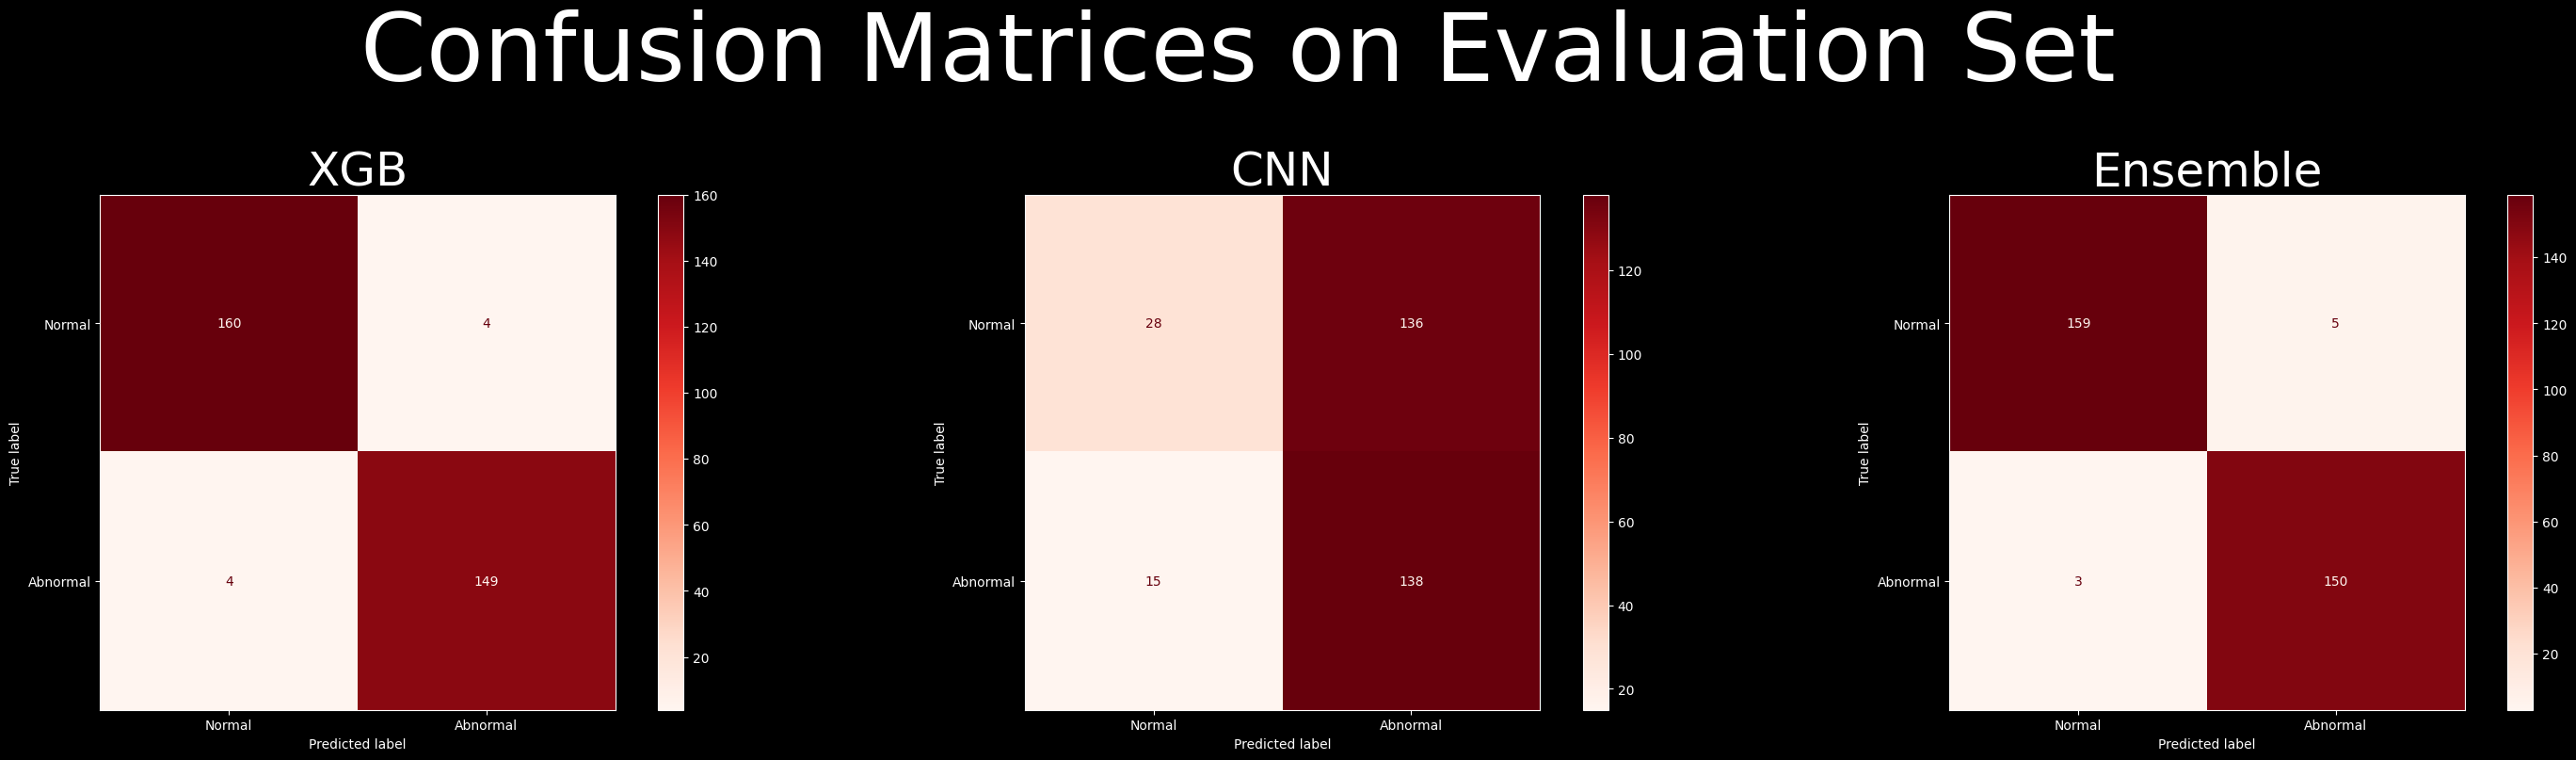

In [76]:
# create figure with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(30, 7.5))
plt.suptitle("Confusion Matrices on Evaluation Set", fontsize = 72, y=1.05)

# XGB confusion matrix
ConfusionMatrixDisplay.from_predictions(
    df_eval_results["y_true"],
    df_eval_results["y_hat_xgb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[0]
)
axes[0].set_title("XGB", fontsize = 36)

# CNN confusion matrix
ConfusionMatrixDisplay.from_predictions(
    df_eval_results["y_true"],
    df_eval_results["y_hat_cnn"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[1]
)
axes[1].set_title("CNN", fontsize = 36)

# ensemble model confusion matrix
ConfusionMatrixDisplay.from_predictions(
    df_eval_results["y_true"],
    df_eval_results["y_hat_comb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[2]
)
axes[2].set_title("Ensemble", fontsize = 36)

plt.tight_layout()
plt.show()

### **Classification Reports**

In [77]:
# XGB classification report
print("XGB Classification Report:\n")
print(classification_report(
    df_eval_results["y_true"],
    df_eval_results["y_hat_xgb"],
    target_names=["Normal", "Abnormal"]
))

# CNN classification report
print("CNN Classification Report:\n")
print(classification_report(
    df_eval_results["y_true"],
    df_eval_results["y_hat_cnn"],
    target_names=["Normal", "Abnormal"]
))

# ensemble classification report
print("Ensemble Classification Report:\n")
print(classification_report(
    df_eval_results["y_true"],
    df_eval_results["y_hat_comb"],
    target_names=["Normal", "Abnormal"]
))

XGB Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       164
    Abnormal       0.97      0.97      0.97       153

    accuracy                           0.97       317
   macro avg       0.97      0.97      0.97       317
weighted avg       0.97      0.97      0.97       317

CNN Classification Report:

              precision    recall  f1-score   support

      Normal       0.65      0.17      0.27       164
    Abnormal       0.50      0.90      0.65       153

    accuracy                           0.52       317
   macro avg       0.58      0.54      0.46       317
weighted avg       0.58      0.52      0.45       317

Ensemble Classification Report:

              precision    recall  f1-score   support

      Normal       0.98      0.97      0.98       164
    Abnormal       0.97      0.98      0.97       153

    accuracy                           0.97       317
   macro avg       0.97      0.97      

## Testing on Unseen Data

### **Loading Test Data**

In [78]:
# read csv files
test_istethoscope = pd.read_csv("set_a.csv")
test_digiscope = pd.read_csv("set_b.csv")

# keep relevant columns
test_istethoscope = test_istethoscope[['fname', 'label']]
test_digiscope = test_digiscope[['fname', 'label']]

# rename for consistency
test_istethoscope.columns = ['Filename', 'Outcome']
test_digiscope.columns = ['Filename', 'Outcome']

# encode them
test_istethoscope["Outcome"] = test_istethoscope["Outcome"].apply(lambda x: 0 if x == "normal" else 1)
test_digiscope["Outcome"] = test_digiscope["Outcome"].apply(lambda x: 0 if x == "normal" else 1)

# show head
test_istethoscope.head(10)

,Filename,Outcome
0,set_a/artifact__201012172012.wav,1
1,set_a/artifact__201105040918.wav,1
2,set_a/artifact__201105041959.wav,1
3,set_a/artifact__201105051017.wav,1
4,set_a/artifact__201105060108.wav,1
5,set_a/artifact__201105061143.wav,1
6,set_a/artifact__201105190800.wav,1
7,set_a/artifact__201105280851.wav,1
8,set_a/artifact__201106010559.wav,1
9,set_a/artifact__201106010602.wav,1


#### Handling Filename Inconsistencies

In [79]:
# delete 'Btraining_'
test_digiscope["Filename"] = (
    test_digiscope["Filename"].str.replace("Btraining_", "", regex=False))

# double underscore for most
test_digiscope["Filename"] = (
    test_digiscope["Filename"]
    .str.replace(r'([A-Za-z]+)_(\d+)', r'\1__\2', regex=True))

# there are special ones with single underscore
raw_string_output = """
Missing: circor-wav/set_b/murmur_noisymurmur__135_1306428972976_A.wav
Missing: circor-wav/set_b/murmur_noisymurmur__135_1306428972976_B.wav
Missing: circor-wav/set_b/murmur_noisymurmur__135_1306428972976_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__156_1306936373241_A.wav
Missing: circor-wav/set_b/murmur_noisymurmur__156_1306936373241_B1.wav
Missing: circor-wav/set_b/murmur_noisymurmur__160_1307100683334_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__161_1307101199321_B.wav
Missing: circor-wav/set_b/murmur_noisymurmur__161_1307101199321_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__162_1307101835989_B__1.wav
Missing: circor-wav/set_b/murmur_noisymurmur__162_1307101835989_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__164_1307106095995_C1.wav
Missing: circor-wav/set_b/murmur_noisymurmur__165_1307109069581_A.wav
Missing: circor-wav/set_b/murmur_noisymurmur__165_1307109069581_C1.wav
Missing: circor-wav/set_b/murmur_noisymurmur__165_1307109069581_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__171_1307971016233_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__171_1307971016233_F.wav
Missing: circor-wav/set_b/murmur_noisymurmur__185_1308073325396_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__200_1308144251434_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__231_1308748318393_A.wav
Missing: circor-wav/set_b/murmur_noisymurmur__240_1309201366049_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__240_1309201366049_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__243_1309197760898_B.wav
Missing: circor-wav/set_b/murmur_noisymurmur__243_1309197760898_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__272_1309370164386_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__288_1311164615284_B1.wav
Missing: circor-wav/set_b/murmur_noisymurmur__288_1311164615284_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__292_1311185449649_D.wav
Missing: circor-wav/set_b/murmur_noisymurmur__293_1311680805936_C.wav
Missing: circor-wav/set_b/murmur_noisymurmur__293_1311680805936_D.wav
Missing: circor-wav/set_b/normal_noisynormal__101_1305030823364_B.wav
Missing: circor-wav/set_b/normal_noisynormal__101_1305030823364_E.wav
Missing: circor-wav/set_b/normal_noisynormal__104_1305032492469_A.wav
Missing: circor-wav/set_b/normal_noisynormal__105_1305033453095_A.wav
Missing: circor-wav/set_b/normal_noisynormal__105_1305033453095_C.wav
Missing: circor-wav/set_b/normal_noisynormal__106_1306776721273_A.wav
Missing: circor-wav/set_b/normal_noisynormal__107_1305654946865_A.wav
Missing: circor-wav/set_b/normal_noisynormal__108_1305654420093_A.wav
Missing: circor-wav/set_b/normal_noisynormal__108_1305654420093_B.wav
Missing: circor-wav/set_b/normal_noisynormal__109_1305653646620_A.wav
Missing: circor-wav/set_b/normal_noisynormal__109_1305653972028_A.wav
Missing: circor-wav/set_b/normal_noisynormal__109_1305653972028_C.wav
Missing: circor-wav/set_b/normal_noisynormal__109_1305653972028_E.wav
Missing: circor-wav/set_b/normal_noisynormal__109_1305653972028_F.wav
Missing: circor-wav/set_b/normal_noisynormal__110_1305655332337_A.wav
Missing: circor-wav/set_b/normal_noisynormal__110_1305655332337_B.wav
Missing: circor-wav/set_b/normal_noisynormal__113_1306244002866_A.wav
Missing: circor-wav/set_b/normal_noisynormal__113_1306244002866_B.wav
Missing: circor-wav/set_b/normal_noisynormal__115_1306259437619_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__115_1306259437619_B.wav
Missing: circor-wav/set_b/normal_noisynormal__117_1306262456650_A.wav
Missing: circor-wav/set_b/normal_noisynormal__117_1306262456650_C.wav
Missing: circor-wav/set_b/normal_noisynormal__117_1306262456650_D.wav
Missing: circor-wav/set_b/normal_noisynormal__118_1306262335509_B.wav
Missing: circor-wav/set_b/normal_noisynormal__118_1306262335509_C1.wav
Missing: circor-wav/set_b/normal_noisynormal__118_1306262335509_D.wav
Missing: circor-wav/set_b/normal_noisynormal__121_1306263877235_A.wav
Missing: circor-wav/set_b/normal_noisynormal__121_1306263877235_C.wav
Missing: circor-wav/set_b/normal_noisynormal__121_1306263877235_D.wav
Missing: circor-wav/set_b/normal_noisynormal__123_1306331925797_B.wav
Missing: circor-wav/set_b/normal_noisynormal__123_1306331925797_C.wav
Missing: circor-wav/set_b/normal_noisynormal__125_1306332456645_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__125_1306332456645_A2.wav
Missing: circor-wav/set_b/normal_noisynormal__125_1306332456645_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__125_1306332456645_C.wav
Missing: circor-wav/set_b/normal_noisynormal__125_1306332456645_D.wav
Missing: circor-wav/set_b/normal_noisynormal__127_1306764300147_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__129_1306344506305_A.wav
Missing: circor-wav/set_b/normal_noisynormal__129_1306344506305_C.wav
Missing: circor-wav/set_b/normal_noisynormal__130_1306347376079_B.wav
Missing: circor-wav/set_b/normal_noisynormal__130_1306347376079_C.wav
Missing: circor-wav/set_b/normal_noisynormal__132_1306758754432_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__132_1306758754432_C.wav
Missing: circor-wav/set_b/normal_noisynormal__133_1306759619127_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__133_1306759619127_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__133_1306759619127_C.wav
Missing: circor-wav/set_b/normal_noisynormal__133_1306759619127_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__134_1306428161797_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__134_1306428161797_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__136_1306429977501_B.wav
Missing: circor-wav/set_b/normal_noisynormal__136_1306429977501_C.wav
Missing: circor-wav/set_b/normal_noisynormal__136_1306429977501_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__137_1306764999211_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__137_1306764999211_A2.wav
Missing: circor-wav/set_b/normal_noisynormal__137_1306764999211_B.wav
Missing: circor-wav/set_b/normal_noisynormal__137_1306764999211_C1.wav
Missing: circor-wav/set_b/normal_noisynormal__137_1306764999211_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__138_1306762146980_A.wav
Missing: circor-wav/set_b/normal_noisynormal__138_1306762146980_D.wav
Missing: circor-wav/set_b/normal_noisynormal__139_1306519274653_D.wav
Missing: circor-wav/set_b/normal_noisynormal__140_1306519735121_C.wav
Missing: circor-wav/set_b/normal_noisynormal__141_1306520154450_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__141_1306520154450_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__141_1306520154450_C1.wav
Missing: circor-wav/set_b/normal_noisynormal__142_1306763049574_A.wav
Missing: circor-wav/set_b/normal_noisynormal__142_1306763049574_B.wav
Missing: circor-wav/set_b/normal_noisynormal__142_1306763049574_D.wav
Missing: circor-wav/set_b/normal_noisynormal__143_1306763822290_A.wav
Missing: circor-wav/set_b/normal_noisynormal__144_1306522408528_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__144_1306522408528_C.wav
Missing: circor-wav/set_b/normal_noisynormal__146_1306778707532_D.wav
Missing: circor-wav/set_b/normal_noisynormal__147_1306523973811_B.wav
Missing: circor-wav/set_b/normal_noisynormal__149_1306776016110_A.wav
Missing: circor-wav/set_b/normal_noisynormal__150_1306776340746_A.wav
Missing: circor-wav/set_b/normal_noisynormal__151_1306779785624_C.wav
Missing: circor-wav/set_b/normal_noisynormal__154_1306935608852_C.wav
Missing: circor-wav/set_b/normal_noisynormal__155_1306935902813_A.wav
Missing: circor-wav/set_b/normal_noisynormal__155_1306935902813_C.wav
Missing: circor-wav/set_b/normal_noisynormal__157_1306937583792_A.wav
Missing: circor-wav/set_b/normal_noisynormal__157_1306937583792_B.wav
Missing: circor-wav/set_b/normal_noisynormal__158_1306947254705_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__158_1306947254705_D.wav
Missing: circor-wav/set_b/normal_noisynormal__159_1307018640315_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__159_1307018640315_B.wav
Missing: circor-wav/set_b/normal_noisynormal__163_1307104470471_D1.wav
Missing: circor-wav/set_b/normal_noisynormal__167_1307111318050_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__167_1307111318050_B.wav
Missing: circor-wav/set_b/normal_noisynormal__168_1307970069434_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__169_1307970398039_A.wav
Missing: circor-wav/set_b/normal_noisynormal__170_1307970562729_C1.wav
Missing: circor-wav/set_b/normal_noisynormal__172_1307971284351_A.wav
Missing: circor-wav/set_b/normal_noisynormal__173_1307973611151_B.wav
Missing: circor-wav/set_b/normal_noisynormal__173_1307973611151_C1.wav
Missing: circor-wav/set_b/normal_noisynormal__176_1307988171173_D.wav
Missing: circor-wav/set_b/normal_noisynormal__178_1307989887769_B1.wav
Missing: circor-wav/set_b/normal_noisynormal__181_1308052613891_A.wav
Missing: circor-wav/set_b/normal_noisynormal__182_1308053371395_B.wav
Missing: circor-wav/set_b/normal_noisynormal__188_1308074301731_A.wav
Missing: circor-wav/set_b/normal_noisynormal__189_1308075231945_A1.wav
Missing: circor-wav/set_b/normal_noisynormal__194_1308139824187_C.wav
Missing: circor-wav/set_b/normal_noisynormal__198_1308141739338_D.wav
Missing: circor-wav/set_b/normal_noisynormal__207_1308159792607_D.wav
Missing: circor-wav/set_b/normal_noisynormal__216_1308245839516_D.wav
Missing: circor-wav/set_b/normal_noisynormal__234_1308748855534_B.wav
Missing: circor-wav/set_b/normal_noisynormal__246_1309199278902_D.wav
Missing: circor-wav/set_b/normal_noisynormal__258_1309352253234_A.wav
Missing: circor-wav/set_b/normal_noisynormal__264_1309356143724_B.wav
Missing: circor-wav/set_b/normal_noisynormal__264_1309356143724_C.wav
Missing: circor-wav/set_b/normal_noisynormal__264_1309356143724_D.wav
Missing: circor-wav/set_b/normal_noisynormal__270_1309369533040_A.wav
Missing: circor-wav/set_b/normal_noisynormal__270_1309369533040_B.wav
Missing: circor-wav/set_b/normal_noisynormal__271_1309369876160_A.wav
Missing: circor-wav/set_b/normal_noisynormal__271_1309369876160_C.wav
Missing: circor-wav/set_b/normal_noisynormal__271_1309369876160_D.wav
Missing: circor-wav/set_b/normal_noisynormal__278_1311163365896_B.wav
Missing: circor-wav/set_b/normal_noisynormal__284_1311168471850_A.wav
Missing: circor-wav/set_b/normal_noisynormal__284_1311168471850_B.wav
Missing: circor-wav/set_b/normal_noisynormal__285_1311169246969_C.wav
Missing: circor-wav/set_b/normal_noisynormal__296_1311682952647_C.wav
Missing: circor-wav/set_b/normal_noisynormal__296_1311682952647_D.wav
"""
# reconstruct filenames that are exceptions
file_list = [
    line.strip().replace('Missing: ', '').replace('missing: ', '').replace('circor-wav/', '')
    for line in raw_string_output.splitlines()
    if line.strip()]
mask = test_digiscope["Filename"].isin(file_list)
test_digiscope.loc[mask, "Filename"] = test_digiscope.loc[mask, "Filename"].str.replace(r'__', r'_', regex=True)

# drop na
test_istethoscope  = test_istethoscope.dropna()
test_digiscope = test_digiscope.dropna()

### **Preprocessing**

In [80]:
# transform test sets for cnn
X_test_istethoscope_cnn = preprocessor_cnn.transform(test_istethoscope.drop(columns=["Outcome"]))
X_test_digiscope_cnn = preprocessor_cnn.transform(test_digiscope.drop(columns=["Outcome"]))

# transform test sets for xgb
X_test_istethoscope_xgb = preprocessor_xgb.transform(test_istethoscope.drop(columns=["Outcome"]))
X_test_digiscope_xgb = preprocessor_xgb.transform(test_digiscope.drop(columns=["Outcome"]))

# save true y
y_test_istethoscope = test_istethoscope["Outcome"].values
y_test_digiscope = test_digiscope["Outcome"].values

# get valid filenames and filter the DataFrame
def filter_dataframe_by_existing_files(df, base_folder):
    valid_filenames = []

    # ensure filtering based on the full path
    for _, row in df.iterrows():
        fname = row["Filename"]
        filepath = os.path.join(base_folder, fname)
        if os.path.isfile(filepath):
            valid_filenames.append(fname)
    return df[df['Filename'].isin(valid_filenames)]

# re-filter test_istethoscope and test_digiscope based on files that actually exist.
test_istethoscope_filtered = filter_dataframe_by_existing_files(test_istethoscope, folder)
test_digiscope_filtered = filter_dataframe_by_existing_files(test_digiscope, folder)

# align y_true with the filtered data
y_test_istethoscope_aligned = test_istethoscope_filtered["Outcome"].values
y_test_digiscope_aligned = test_digiscope_filtered["Outcome"].values

Missing: circor-wav/set_a/__201012172010.wav
Missing: circor-wav/set_a/__201101051105.wav
Missing: circor-wav/set_a/__201101061552.wav
Missing: circor-wav/set_a/__201101091156.wav
Missing: circor-wav/set_a/__201101110659.wav
Missing: circor-wav/set_a/__201101152256.wav
Missing: circor-wav/set_a/__201101220549.wav
Missing: circor-wav/set_a/__201101241434.wav
Missing: circor-wav/set_a/__201102081033.wav
Missing: circor-wav/set_a/__201102081045.wav
Missing: circor-wav/set_a/__201102200848.wav
Missing: circor-wav/set_a/__201103011036.wav
Missing: circor-wav/set_a/__201103140236.wav
Missing: circor-wav/set_a/__201103170122.wav
Missing: circor-wav/set_a/__201103200518.wav
Missing: circor-wav/set_a/__201103201314.wav
Missing: circor-wav/set_a/__201103232251.wav
Missing: circor-wav/set_a/__201103241336.wav
Missing: circor-wav/set_a/__201104012144.wav
Missing: circor-wav/set_a/__2011040239.wav
Missing: circor-wav/set_a/__201105011546.wav
Missing: circor-wav/set_a/__20110501548.wav
Missing: circ

### **Prediction DataFrames**

In [81]:
# predicted probabilitie
y_hat_istethoscope_xgb_proba = xgb_model.predict_proba(X_test_istethoscope_xgb)[:, 1]
y_hat_digiscope_xgb_proba = xgb_model.predict_proba(X_test_digiscope_xgb)[:, 1]

# predicted class (threshold = 0.5)
y_hat_istethoscope_xgb = (y_hat_istethoscope_xgb_proba >= 0.5).astype(int)
y_hat_digiscope_xgb = (y_hat_digiscope_xgb_proba >= 0.5).astype(int)

# get CNN predictions
y_hat_istethoscope_cnn_proba = model.predict(X_test_istethoscope_cnn).flatten()
y_hat_digiscope_cnn_proba = model.predict(X_test_digiscope_cnn).flatten()

# predicted class (threshold = 0.5)
y_hat_istethoscope_cnn = (y_hat_istethoscope_cnn_proba >= 0.5).astype(int)
y_hat_digiscope_cnn = (y_hat_digiscope_cnn_proba >= 0.5).astype(int)

# ensemble
y_hat_istethoscope_comb_proba = (y_hat_istethoscope_xgb_proba + y_hat_istethoscope_cnn_proba) / 2
y_hat_digiscope_comb_proba = (y_hat_digiscope_xgb_proba + y_hat_digiscope_cnn_proba) / 2
y_hat_istethoscope_comb = (y_hat_istethoscope_comb_proba >= 0.5).astype(int)
y_hat_digiscope_comb = (y_hat_digiscope_comb_proba >= 0.5).astype(int)

# create df
test_results_istethoscope = pd.DataFrame({
    "y_true": y_test_istethoscope_aligned,
    "y_hat_xgb_proba": y_hat_istethoscope_xgb_proba,
    "y_hat_xgb": y_hat_istethoscope_xgb,
    "y_hat_cnn_proba": y_hat_istethoscope_cnn_proba,
    "y_hat_cnn": y_hat_istethoscope_cnn,
    "y_hat_comb_proba": y_hat_istethoscope_comb_proba,
    "y_hat_comb": y_hat_istethoscope_comb
})

# create df
test_results_digiscope = pd.DataFrame({
    "y_true": y_test_digiscope_aligned,
    "y_hat_xgb_proba": y_hat_digiscope_xgb_proba,
    "y_hat_xgb": y_hat_digiscope_xgb,
    "y_hat_cnn_proba": y_hat_digiscope_cnn_proba,
    "y_hat_cnn": y_hat_digiscope_cnn,
    "y_hat_comb_proba": y_hat_digiscope_comb_proba,
    "y_hat_comb": y_hat_digiscope_comb
})

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


### **Confusion Matrices**

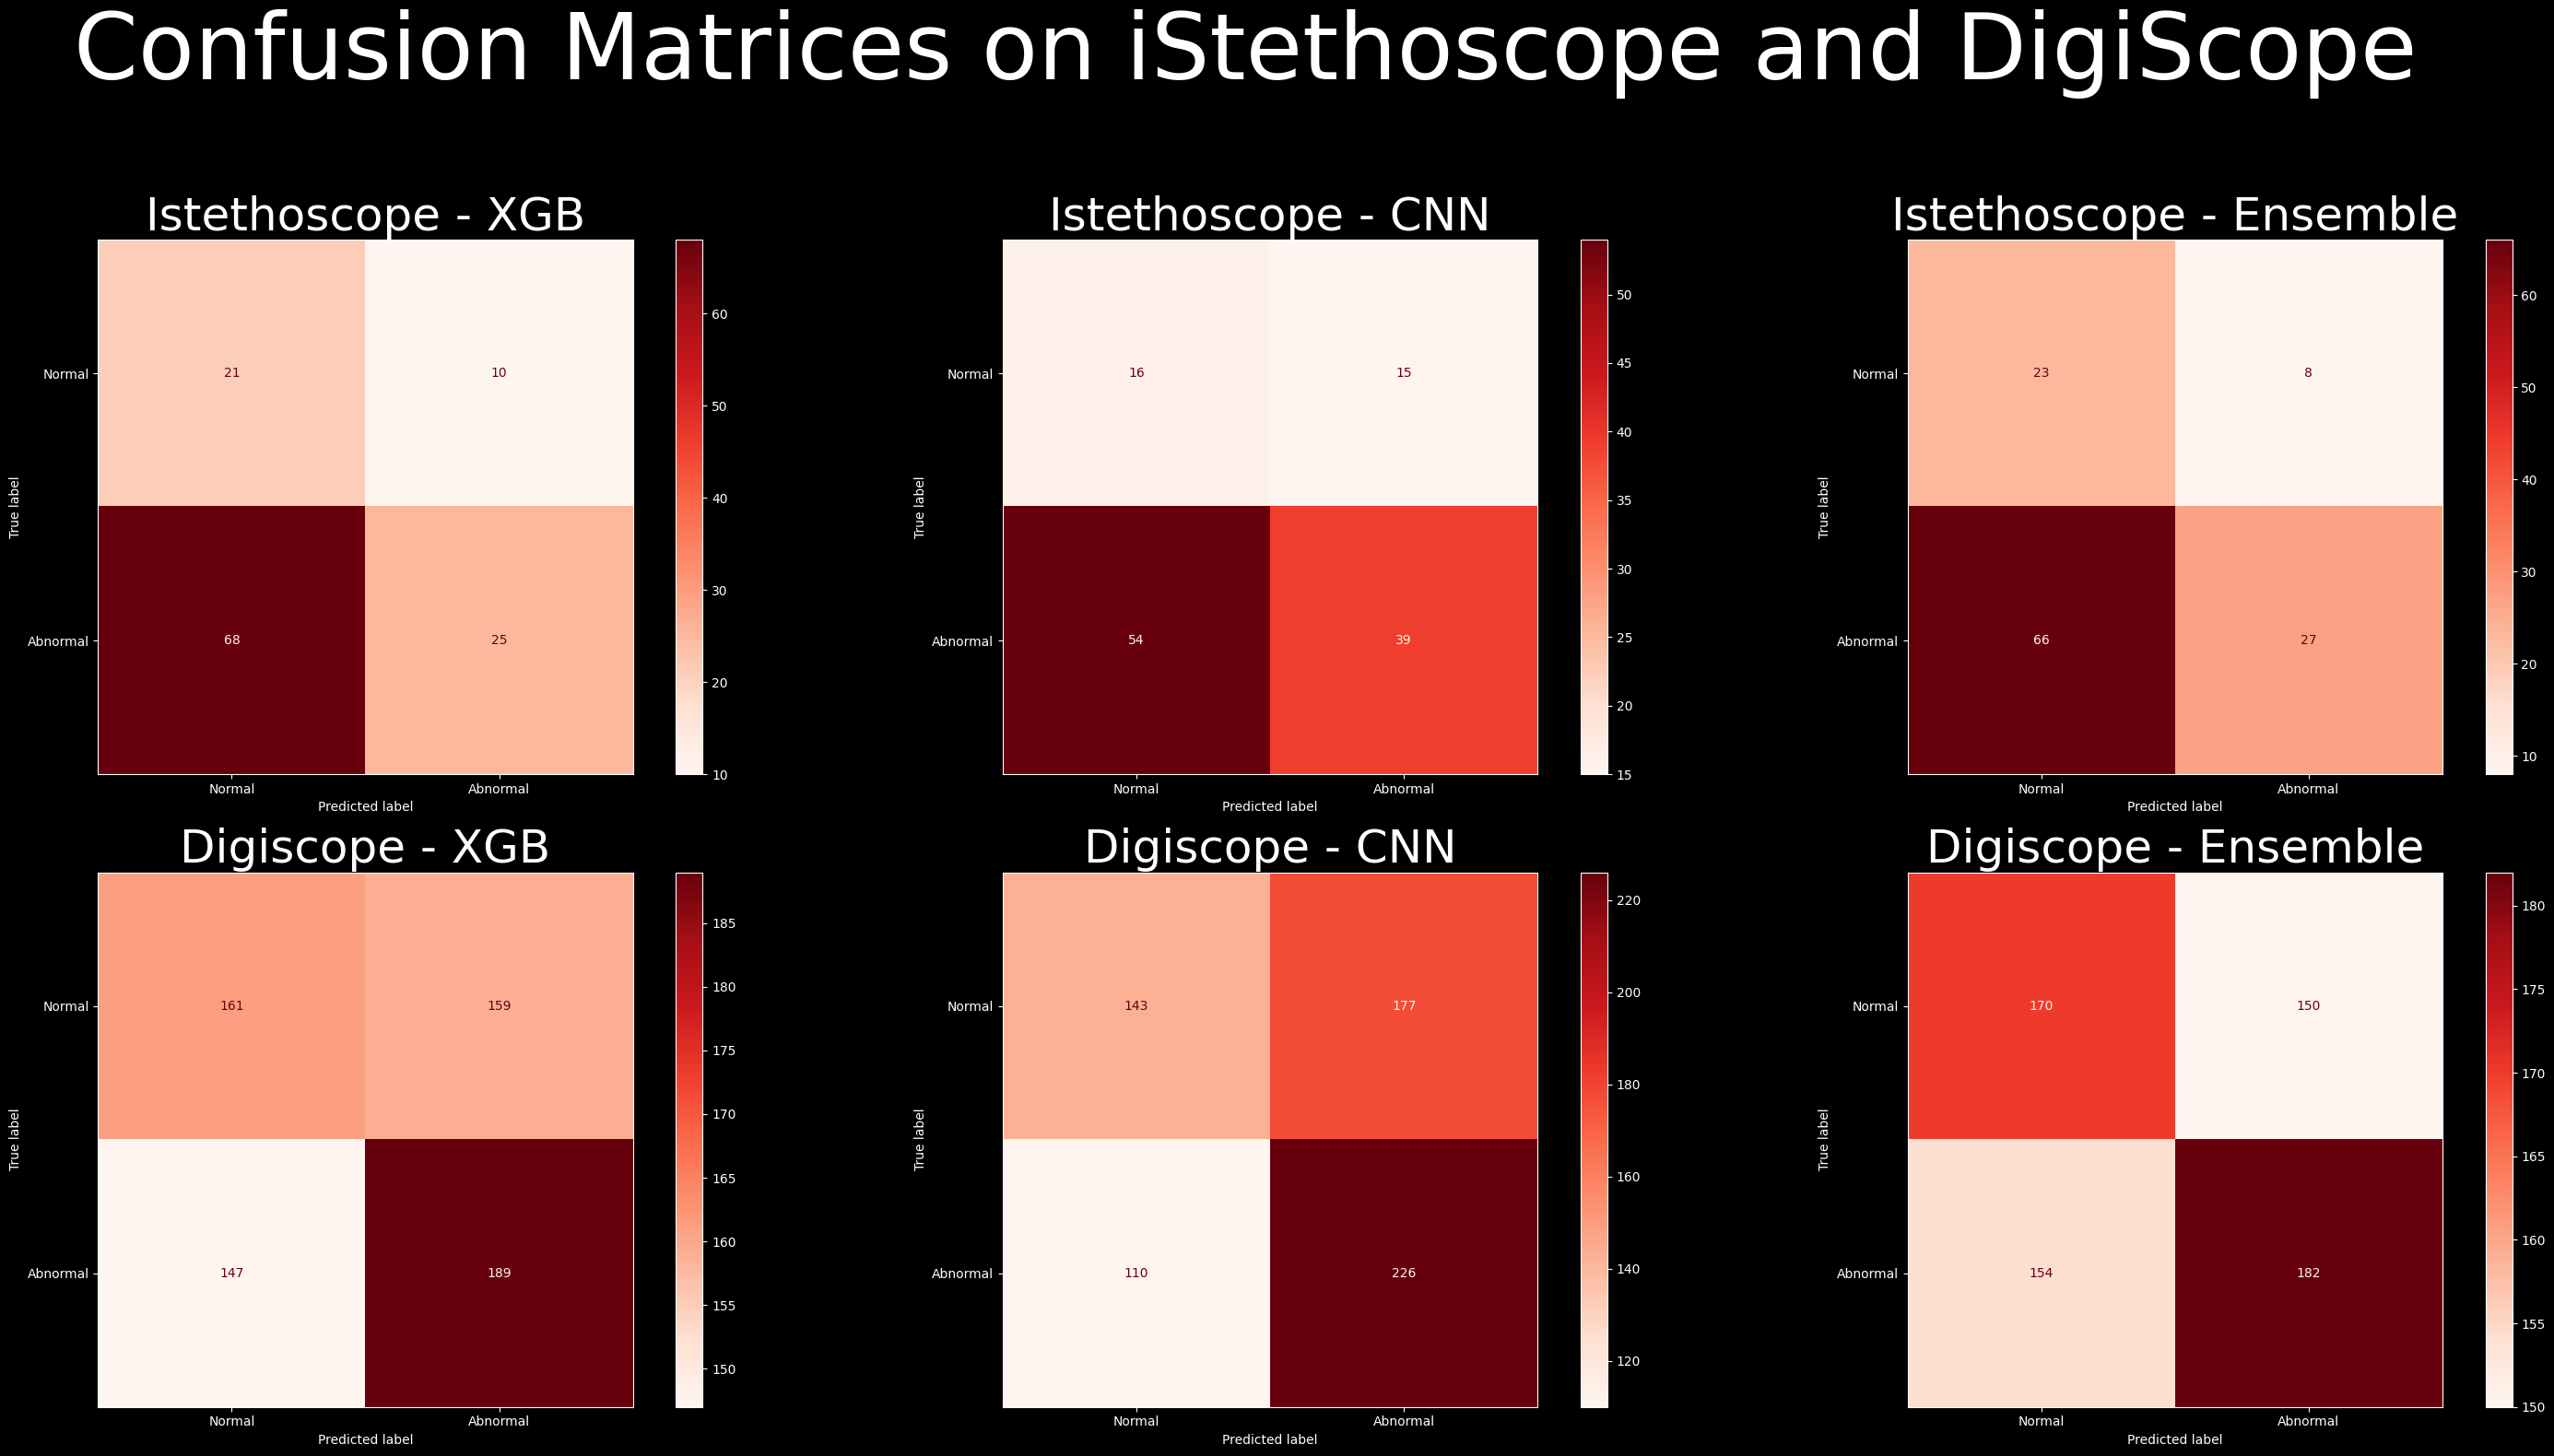

In [82]:
# create figure with 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
plt.suptitle("Confusion Matrices on iStethoscope and DigiScope", fontsize = 72, y=1.05)
# Istethoscope – XGB
ConfusionMatrixDisplay.from_predictions(
    test_results_istethoscope["y_true"],
    test_results_istethoscope["y_hat_xgb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Istethoscope - XGB", fontsize = 36)

# Istethoscope – CNN
ConfusionMatrixDisplay.from_predictions(
    test_results_istethoscope["y_true"],
    test_results_istethoscope["y_hat_cnn"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Istethoscope - CNN", fontsize = 36)

# Istethoscope – Combined
ConfusionMatrixDisplay.from_predictions(
    test_results_istethoscope["y_true"],
    test_results_istethoscope["y_hat_comb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[0, 2]
)
axes[0, 2].set_title("Istethoscope - Ensemble", fontsize = 36)

# Digiscope – XGB
ConfusionMatrixDisplay.from_predictions(
    test_results_digiscope["y_true"],
    test_results_digiscope["y_hat_xgb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Digiscope - XGB", fontsize = 36)

# Digiscope – CNN
ConfusionMatrixDisplay.from_predictions(
    test_results_digiscope["y_true"],
    test_results_digiscope["y_hat_cnn"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Digiscope - CNN", fontsize = 36)

# Digiscope – Combined
ConfusionMatrixDisplay.from_predictions(
    test_results_digiscope["y_true"],
    test_results_digiscope["y_hat_comb"],
    display_labels=["Normal", "Abnormal"],
    cmap="Reds",
    normalize=None,
    ax=axes[1, 2]
)
axes[1, 2].set_title("Digiscope - Ensemble", fontsize = 36)

plt.tight_layout()
plt.show()

### **Classification Reports**

In [83]:
for df in [test_results_istethoscope, test_results_digiscope]:

  # depending on data
  if df is test_results_istethoscope:
    data = "Istethoscope"
  else:
    data = "Digiscope"

  print(80*"_")

  # XGB classification report
  print(f"XGB Classification Report for {data}:\n")
  print(classification_report(
      df["y_true"],
      df["y_hat_xgb"],
      target_names=["Normal", "Abnormal"]
  ))

  # CNN classification report
  print(f"CNN Classification Report for {data}:\n")
  print(classification_report(
      df["y_true"],
      df["y_hat_cnn"],
      target_names=["Normal", "Abnormal"]
  ))

  # Ensemble classification report
  print(f"Ensemble Classification Report for {data}:\n")
  print(classification_report(
      df["y_true"],
      df["y_hat_comb"],
      target_names=["Normal", "Abnormal"]
  ))

________________________________________________________________________________
XGB Classification Report for Istethoscope:

              precision    recall  f1-score   support

      Normal       0.24      0.68      0.35        31
    Abnormal       0.71      0.27      0.39        93

    accuracy                           0.37       124
   macro avg       0.48      0.47      0.37       124
weighted avg       0.59      0.37      0.38       124

CNN Classification Report for Istethoscope:

              precision    recall  f1-score   support

      Normal       0.23      0.52      0.32        31
    Abnormal       0.72      0.42      0.53        93

    accuracy                           0.44       124
   macro avg       0.48      0.47      0.42       124
weighted avg       0.60      0.44      0.48       124

Ensemble Classification Report for Istethoscope:

              precision    recall  f1-score   support

      Normal       0.26      0.74      0.38        31
    Abnormal    